In [3]:
pip install protobuf==3.20.*


  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
Note: you may need to restart the kernel to use updated packages.


ERROR: tensorflow-intel 2.11.0 has requirement protobuf<3.20,>=3.9.2, but you'll have protobuf 3.20.3 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\farre\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\google\\~rotobuf\\internal\\_api_implementation.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\Users\farre\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import streamlit as st
import joblib

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
df = pd.read_csv('ispu_dki1.csv')
df.head()

,tanggal,stasiun,pm25,pm10,so2,co,o3,no2,max,critical,categori
0,2010-01-01,DKI1 (Bunderan HI),NaN,60.0,4.0,73.0,27.0,14.0,73.0,CO,SEDANG
1,2010-01-02,DKI1 (Bunderan HI),NaN,32.0,2.0,16.0,33.0,9.0,33.0,O3,BAIK
2,2010-01-03,DKI1 (Bunderan HI),NaN,27.0,2.0,19.0,20.0,9.0,27.0,PM10,BAIK
3,2010-01-04,DKI1 (Bunderan HI),NaN,22.0,2.0,16.0,15.0,6.0,22.0,PM10,BAIK
4,2010-01-05,DKI1 (Bunderan HI),NaN,25.0,2.0,17.0,15.0,8.0,25.0,PM10,BAIK


In [16]:
df.shape

(5059, 11)

### DATA PREPROCESSING

In [7]:
categories = ['BAIK', 'SEDANG', 'TIDAK SEHAT']
df = df[df['categori'].isin(categories)]

In [9]:
df.isnull().sum()

tanggal        0
stasiun        0
pm25        3913
pm10         102
so2           74
co            54
o3            95
no2           85
max            0
critical       0
categori       0
dtype: int64

In [17]:
features = ['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']
for col in ['pm25', 'pm10', 'so2', 'co', 'o3', 'no2']:
    df[col] = df[col].fillna(df[col].mean())

df.isnull().sum()

tanggal     0
stasiun     0
pm25        0
pm10        0
so2         0
co          0
o3          0
no2         0
max         0
critical    0
categori    0
dtype: int64

In [18]:
le = LabelEncoder()
y = le.fit_transform(df['categori'])

In [19]:
scaler = StandardScaler()
X = scaler.fit_transform(df[features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
print("Train set distribution:", np.unique(y_train, return_counts=True))
print("Test set distribution:", np.unique(y_test, return_counts=True))

Train set distribution: (array([0, 1, 2]), array([ 951, 2947,  149], dtype=int64))
Test set distribution: (array([0, 1, 2]), array([238, 737,  37], dtype=int64))


### MACHINE LEARNING MODEL

In [22]:
def build_model(input_shape, num_classes):
    inputs = Input(shape=(input_shape,))
    
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [23]:
model = build_model(X_train.shape[1], len(le.classes_))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 128)               896       
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                             

### MODEL TRAINING

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1)

Epoch 1/100
127/127 [==============================] - 5s 9ms/step - loss: 0.6640 - accuracy: 0.7499 - val_loss: 0.5183 - val_accuracy: 0.7964
Epoch 2/100
127/127 [==============================] - 1s 5ms/step - loss: 0.3605 - accuracy: 0.8826 - val_loss: 0.3623 - val_accuracy: 0.8449
Epoch 3/100
127/127 [==============================] - 1s 5ms/step - loss: 0.2728 - accuracy: 0.9044 - val_loss: 0.2458 - val_accuracy: 0.8953
Epoch 4/100
127/127 [==============================] - 1s 5ms/step - loss: 0.2585 - accuracy: 0.9036 - val_loss: 0.1641 - val_accuracy: 0.9348
Epoch 5/100
127/127 [==============================] - 1s 5ms/step - loss: 0.2302 - accuracy: 0.9113 - val_loss: 0.1366 - val_accuracy: 0.9545
Epoch 6/100
127/127 [==============================] - 1s 5ms/step - loss: 0.2215 - accuracy: 0.9148 - val_loss: 0.1370 - val_accuracy: 0.9555
Epoch 7/100
127/127 [==============================] - 1s 5ms/step - loss: 0.2324 - accuracy: 0.9115 - val_loss: 0.1250 - val_accuracy: 0.9565

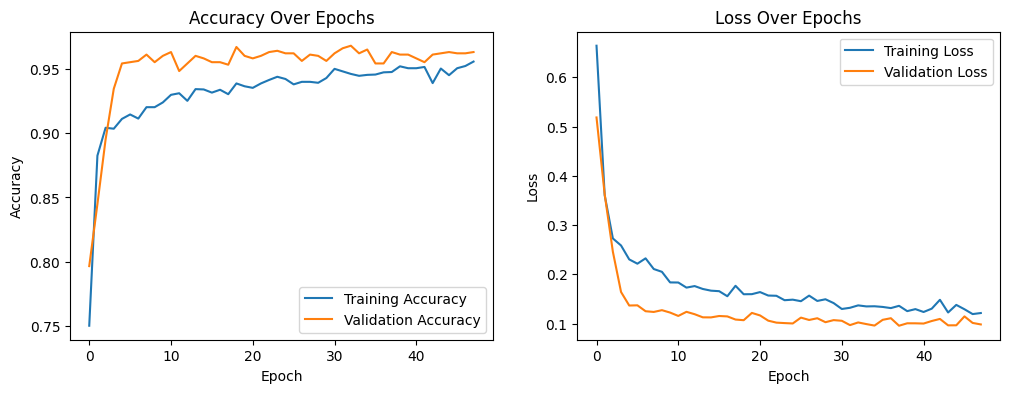

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### MODEL EVALUATION

In [26]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

32/32 [==============================] - 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

        BAIK       0.95      0.92      0.94       238
      SEDANG       0.97      0.99      0.98       737
 TIDAK SEHAT       1.00      0.81      0.90        37

    accuracy                           0.96      1012
   macro avg       0.97      0.91      0.94      1012
weighted avg       0.96      0.96      0.96      1012



In [ ]:
model.save('air_quality_model.h5')
joblib.dump(scaler, 'scaler_modified.pkl')
joblib.dump(le, 'label_encoder_modified.pkl')